In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
widthStripesAmount=48
heightStripesAmount=64


In [115]:
def CalculateStripMiddle(stripe, stripewidth):
    diagnose=0
    if(diagnose==1): print("CalculateStripMiddle")
    imgResized=cv2.resize(stripe, (int(stripewidth/4), 1),  interpolation = cv2.INTER_AREA)[0,:]
    if(diagnose==1):
        img=cv2.resize(stripe, (int(stripewidth), 1),  interpolation = cv2.INTER_AREA)[0,:]
        plt.plot(img)
        plt.show()
    middleWidth=stripewidth/2  #Niewiadomo, dlatego centralnie środek
    maxims=[]
    windowWidthEdge=3
    windowWidthMiddle=12
    for i in range (windowWidthMiddle, imgResized.shape[0]-windowWidthMiddle-1, 1):
        windowWidth=round(max(windowWidthMiddle-abs((middleWidth-i)/middleWidth*(windowWidthMiddle-windowWidthEdge)),windowWidthEdge))
        #print(windowWidth)
        if(imgResized[i]==max(imgResized[i-windowWidth:i+windowWidth])):
            if(len(maxims)>0 and int((maxims[-1]+windowWidth))<i*4):
                maxims.append(i*4)
            elif(len(maxims)==0):
                maxims.append(i*4)
            elif(int((maxims[-1]+windowWidth))>i*4):
                maxims[-1]=(maxims[-1]+i*4)/2

    maxims=np.array(maxims)
    diffs=np.diff(maxims)
    ind=np.argpartition(diffs,-2)[-2:]
    if(diagnose==1):
        print("maxims", maxims)
        print("diffs", diffs)
        print("ind", ind)
    #[10, 30, 100, 120, 190, 210]
    #[20, 70, 20, 70, 20]
    #[10, 30, 40, 180, 200, 210]
    #[20, 10, 120, 20, 10]
    
    StripMiddle=0
    if(abs(ind[0]-ind[1])==1):
        #ind=np.argpartition(diffs,-1)[-1:]
        #StripMiddle=(maxims[ind[0]]+maxims[ind[0]+1])/2
        StripMiddle=(maxims[min(ind)]+maxims[max(ind)+1])/2
    else:
        StripMiddle=(maxims[min(ind)+1]+maxims[max(ind)])/2
    if(diagnose==1):
        print("StripMiddle", StripMiddle)
    #if(ind[0]>ind[1]): ind[0]+=1                        ############ToCheck
    #else: ind[1]+=1                                     ############ToCheck
    
    #ind[0]+=1
    #ind[1]+=1
    #StripMiddle=int(np.mean(maxims[ind]))
    return int(StripMiddle)

def WidthMiddleFind(img, stripesAmount):
    height, width=img.shape
    stripesMeans=[]
    for i in range (0, height-int(height/stripesAmount), int(height/stripesAmount)):
        stripe=img[i: i+int(height/stripesAmount), : ]
        #print(CalculateStripMiddle(stripe))
        oneStripeMean=CalculateStripMiddle(stripe, width)
        stripesMeans.append(oneStripeMean)
    widthMiddle=int(np.round(np.mean(stripesMeans)))
    return widthMiddle

def WidthHeighFind(img, stripesAmount):
    height, width=img.shape
    stripesMeans=[]
    for i in range (0, width-int(width/stripesAmount), int(width/stripesAmount)):
        stripe=img[:, i: i+int(width/stripesAmount) ]
        stripe=stripe.transpose()
        #print(CalculateStripMiddle(stripe))
        oneStripeMean=CalculateStripMiddle(stripe, height)
        stripesMeans.append(oneStripeMean)
    heightMiddle=int(np.round(np.mean(stripesMeans)))
    return heightMiddle

def FindMiddle(img, widthStripesAmount, heightStripesAmount):
    img=img[4:484, 4:644]
    
    middleWidth=WidthMiddleFind(img, widthStripesAmount)
    middleHeight=WidthHeighFind(img, heightStripesAmount)
    return middleWidth, middleHeight

def CalculateEpsilon(img, widthStripesAmount, heightStripesAmount):
    middleWidth, middleHeight=FindMiddle(img, widthStripesAmount, heightStripesAmount)
    print(middleWidth, middleHeight)
    #img = cv2.imread("../data/raw/1channel/medianedphoto/00000.png", cv2.IMREAD_GRAYSCALE)
    img=img[4:484, 4:644]
    stripeWidth=img.shape[1]
    stripe=img[(middleHeight-20):(middleHeight+20),:]

    #print(stripe.shape)
    imgResized=cv2.resize(stripe, (int(stripeWidth/4), 1),  interpolation = cv2.INTER_AREA)[0,:]
    imgResizedPlot=cv2.resize(stripe, (int(stripeWidth), 1),  interpolation = cv2.INTER_AREA)[0,:]
    #print(imgResized.shape)

    #in middle- 15 pixels
    #mid in 320
    #abs((320-i)/320*10)
    maxims=[]
    windowWidthEdge=5
    windowWidthMiddle=12
    for i in range (windowWidthEdge, imgResized.shape[0]-windowWidthEdge-1, 1):
        windowWidth=round(max(windowWidthMiddle-abs((middleWidth-i)/middleWidth*(windowWidthMiddle-windowWidthEdge)),windowWidthEdge))
        #print(windowWidth)
        if(imgResized[i]==max(imgResized[i-windowWidth:i+windowWidth])):
            if(len(maxims)>0 and int((maxims[-1]+windowWidth))<i*4):
                maxims.append(i*4)
            elif(len(maxims)==0):
                maxims.append(i*4)
            elif(int((maxims[-1]+windowWidth))>i*4):
                maxims[-1]=(maxims[-1]+i*4)/2

    maxims=np.array(maxims)
    
    plt.plot(imgResizedPlot)
    for maxim in maxims:
        plt.axvline(maxim,0,1, color='r')
    

    diffs=np.diff(maxims)
    ind=np.argpartition(diffs,-2)[-2:]
    #print("maxims:", maxims)
    print("ind",ind)
    print("maxims",maxims)
    #if(ind[0]>ind[1]): ind[0]+=1
    #else: ind[1]+=1
    #StripMiddle=int(np.mean(maxims[ind]))
    #StripMiddle=middleWidth
    StripMiddle=0
    if(abs(ind[0]-ind[1])==1):
        #ind=np.argpartition(diffs,-1)[-1:]
        #StripMiddle=(maxims[ind[0]]+maxims[ind[0]+1])/2
        StripMiddle=(maxims[min(ind)]+maxims[max(ind)+1])/2
    else:
        StripMiddle=(maxims[min(ind)+1]+maxims[max(ind)])/2
    
    StripMiddle=middleWidth
    #StripMiddle=310
    print("StripMiddle",StripMiddle)
    halfMaxims=[i for i in maxims if i>=StripMiddle ]
    print("halfMaxims",halfMaxims)
    if(halfMaxims[1]-halfMaxims[0]<halfMaxims[2]-halfMaxims[1]):
        halfMaxims[1]=(halfMaxims[0]+halfMaxims[1])/2
        halfMaxims.pop(0)
    for halfMaxim in halfMaxims:
        plt.axvline(halfMaxim,0.25,0.75, color='g')
    plt.axvline(StripMiddle, 0.25, 0.75, color='b')
    plt.show()
    halfMaxims=[(i-StripMiddle)*(i-StripMiddle) for i in halfMaxims]
    halfMaxims.insert(0,0)
    #print(halfMaxims)
    pointsNumber=len(halfMaxims)
    
    #PlotParameters


    #a=(halfMaxims[pointsNumber-1]-halfMaxims[1])/(pointsNumber-1)
    #b=halfMaxims[pointsNumber-1]-pointsNumber*a
    #a=(halfMaxims[3]-halfMaxims[1])/(3-1)
    #b=halfMaxims[1]-a
    a=(halfMaxims[3]-halfMaxims[2])
    b=halfMaxims[2]-2*a

    #print(a)
    #print(b)
    epsilon=abs(1-abs(b/a))
    #print(epsilon)
    plt.plot(halfMaxims)
    calculatedPlot=[]
    for i in range (len(halfMaxims)):
        calculatedPlot.append(i*a+b)
    plt.plot(calculatedPlot, c='r')
    plt.show()
    return epsilon


315 257
ind [5 4]
maxims [ 20.  52.  88. 128. 180. 350. 444. 496. 540.]
StripMiddle 315
halfMaxims [350.0, 444.0, 496.0, 540.0]


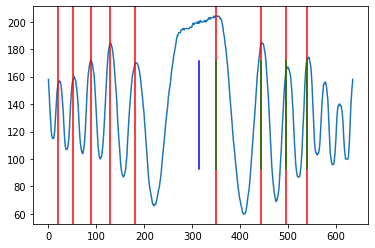

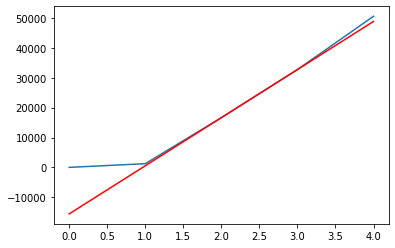

0.0323200992555831


In [119]:
img = cv2.imread("../data/generated/noised/medianedphoto/00140.png", cv2.IMREAD_GRAYSCALE)

print(CalculateEpsilon(img, widthStripesAmount, heightStripesAmount))
